# **SDGym - Synthetic Data Gym**

**Synthetic Data Gym** (SDGym) is a framework to benchmark the performance of synthetic data generators based on SDV and SDMetrics:

*   Learn a tabular model to synthesize rows in a table
*   Learn a relational data model to synthesize multiple, related tables
*   Learn a time-series model to synthesize new events

GitHub Link: https://github.com/sdv-dev/SDGym

A **Synthetic Data Generator** is a Python function (or method) that takes as input some data, which we call the real data, learns a model from it, and outputs new synthetic data that has the same structure and similar mathematical properties as the real one.

In [ ]:
import os
import platform
OS = platform.system()   # Operating System                                                             # returns 'Windows', 'Linux', etc

# **Libraries Installation Section**

Installation of all required libraries: SDGym, gdown, pandas

In [ ]:
os.system('pip install --upgrade --no-cache-dir gdown')
os.system('pip install sdgym')
os.system('pip install pandas')

0

# **All Imports**

In [ ]:
import timeit
import numpy as np
import pandas as pd
from sdv.demo import load_tabular_demo
from sdv.tabular import GaussianCopula, CTGAN, CopulaGAN
from sdv.evaluation import evaluate

# **All Globals**

In [ ]:
benchmark = False
gaussian_copula_synth_model = False
ctgan_synth_model = False
copula_gan_synth_model = True
dataset = 'telephony'   # satgpa, acs, telephony
model_names = []
limit_to_generate = 1000  # or None

# **All Settings**

In [ ]:
start_global_time = timeit.default_timer()
pd.set_option('display.max_columns', 500) 
pd.set_option('display.max_rows', 500) 
if ctgan_synth_model == True and copula_gan_synth_model == True: # Only one Gan 
  ctgan_synth_model = False

# **All Functions Definitions**

In [ ]:
def explore_data(data): 
  print("\nHead of Data: \n", data.head())
  print("\nTail of Data: \n", data.tail())
  print("\nShape of Data: ", data.shape)
  print("\nInformation about Data: \n")
  try: 
    data.info()
  except: 
    pass
  print("\nTypes of Data attributes: \n")
  try: 
    data.dtypes
  except: 
    pass
  print("\nSummary of all numerical fields in the dataset: \n")
  try: 
    data.describe(include = [np.number])
  except: 
    pass
  print("\nSummary of all categorical fields in the dataset: \n")
  try: 
    data.describe(include = ['O'])
  except: 
    pass
  print("\nLoop Through Each Column and Check for nulls: \n")
  try: 
    for i in range(len(data.columns)):
        print(data.columns[i] + ": " + str(data[data.columns[i]].isna().sum()))
  except: 
    pass

def data_download(file_to_download, gdrive_code, OS, uncompress = True):
  if not os.path.exists(file_to_download):
    os.system('gdown --id "'+gdrive_code+'" --output '+file_to_download)
    if OS == "Linux" and uncompress:
        os.system('unzip -o -n "./'+file_to_download+'" -d "./"')
    return True
  else: 
    return None

# **Data Download - ACS, SatGPA, Telephony**

In [ ]:
if benchmark == True: 
  data = load_tabular_demo('student_placements')
  n_to_generate = data.shape[0]
else: 
  if dataset is 'satgpa':
    out = data_download("./satgpa.csv", "1NNVF1LhBDkW_KKp5_QW8cAiQDFatzWMy", OS, False)
    data = pd.read_csv('./satgpa.csv')
    data = data.drop(['sat_sum'], axis=1)
    data.to_csv('satgpa_no_sum.csv', sep=',')
    n_to_generate = data.shape[0]
  elif dataset is 'acs':
    out = data_download("./acs_dataset.zip", "1mKZfDieGBJP-cS-R7_i3zVKVawXThfUc", OS)
    if limit_to_generate is not None: 
      data = pd.read_csv('./acs_dataset.csv', nrows = limit_to_generate)
      n_to_generate = limit_to_generate
    else: 
      data = pd.read_csv('./acs_dataset.csv')
      n_to_generate = data.shape[0]
  elif dataset is 'telephony':
    out = data_download("./syntetic_telephony.zip", "1knlC9DQ-iQhxwpmd9qzFWSS0OcgI9-LA", OS)
    xl_file = pd.ExcelFile('./syntetic_telephony.xlsx')
    dfs = {sheet_name: xl_file.parse(sheet_name) for sheet_name in xl_file.sheet_names}
    data = dfs['Sheet1']
    n_to_generate = data.shape[0]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CHIAVE_NUM_CHIAMANTE  10000 non-null  float64
 1   DATA_CHIAMATA         10000 non-null  int64  
 2   ORA_MIN_CHIAMATA      10000 non-null  int64  
 3   COD_CELLA_CHIAMATA    10000 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 312.6 KB


# **Exploratory Analysis**

In [ ]:
data.COD_CELLA_CHIAMATA=data.COD_CELLA_CHIAMATA.astype("int64").astype("str")
data["COD_CELLA_CHIAMATA"]="F"+data.COD_CELLA_CHIAMATA

data.DATA_CHIAMATA=pd.to_datetime(data.DATA_CHIAMATA, format='%Y%m%d')
data.CHIAVE_NUM_CHIAMANTE=data.CHIAVE_NUM_CHIAMANTE.astype("int64").astype("str")
data["CHIAVE_NUM_CHIAMANTE"]="F"+data.CHIAVE_NUM_CHIAMANTE

data.ORA_MIN_CHIAMATA=data.ORA_MIN_CHIAMATA.astype("str").str.pad(width=6, side='left', fillchar='0')
data.ORA_MIN_CHIAMATA =pd.to_datetime(data.ORA_MIN_CHIAMATA , format='%H%M%S')


In [ ]:
display(data.head(4))
data.info()

,CHIAVE_NUM_CHIAMANTE,DATA_CHIAMATA,ORA_MIN_CHIAMATA,COD_CELLA_CHIAMATA
0,F14615194667453690,2017-01-22,1900-01-01 15:49:53,F0
1,F14615194667453690,2017-01-29,1900-01-01 12:40:34,F1
2,F14615194667453690,2017-01-29,1900-01-01 12:41:19,F1
3,F14615194667453690,2017-01-22,1900-01-01 15:51:02,F1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   CHIAVE_NUM_CHIAMANTE  10000 non-null  object        
 1   DATA_CHIAMATA         10000 non-null  datetime64[ns]
 2   ORA_MIN_CHIAMATA      10000 non-null  datetime64[ns]
 3   COD_CELLA_CHIAMATA    10000 non-null  object        
dtypes: datetime64[ns](2), object(2)
memory usage: 312.6+ KB


In [ ]:

pd.DataFrame(data.CHIAVE_NUM_CHIAMANTE.value_counts()).hist(bins=20)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f71d0315410>]],
      dtype=object)

ImportError: ignored

<Figure size 432x288 with 1 Axes>

In [ ]:
explore_data(data)


Head of Data: 
   CHIAVE_NUM_CHIAMANTE DATA_CHIAMATA    ORA_MIN_CHIAMATA COD_CELLA_CHIAMATA
0   F14615194667453690    2017-01-22 1900-01-01 15:49:53                 F0
1   F14615194667453690    2017-01-29 1900-01-01 12:40:34                 F1
2   F14615194667453690    2017-01-29 1900-01-01 12:41:19                 F1
3   F14615194667453690    2017-01-22 1900-01-01 15:51:02                 F1
4   F14615194667453690    2017-01-22 1900-01-01 15:51:38                 F1

Tail of Data: 
      CHIAVE_NUM_CHIAMANTE DATA_CHIAMATA    ORA_MIN_CHIAMATA COD_CELLA_CHIAMATA
9995   F14615368752090240    2017-01-12 1900-01-01 12:09:10               F272
9996   F14615368752090240    2017-02-12 1900-01-01 18:26:01               F272
9997    F1508338528891430    2017-01-04 1900-01-01 09:26:27               F272
9998   F14615368752090240    2017-02-10 1900-01-01 15:11:58               F272
9999   F14615337422429130    2017-01-30 1900-01-01 09:09:03               F272

Shape of Data:  (10000, 4)

Informa

# **Synthetic Data Generation via Gaussian Copula Method**

In mathematical terms, a copula is a distribution over the unit cube [0,1]d which is constructed from a multivariate normal distribution over Rd by using the probability integral transform. Intuitively, a copula is a mathematical function that allows us to describe the joint distribution of multiple random variables by analyzing the dependencies between their marginal distributions.

In [ ]:
if gaussian_copula_synth_model == True:
  model = GaussianCopula()
  model.fit(data)
  model_names.append(dataset+'_gaussian_copula.pkl')
  model.save(model_names[-1])

# **Synthetic Data Generation via Conditional GAN**

Modeling the probability distribution of rows in tabular data and generating realistic synthetic data is a non-trivial task. Tabular data usually contains a mix of discrete and continuous columns. Continuous columns may have multiple modes whereas discrete columns are sometimes imbalanced making the modeling difficult. Existing statistical and deep neural network models fail to properly model this type of data. We design TGAN, which uses a conditional generative adversarial network to address these challenges. To aid in a fair and thorough comparison, we design a benchmark with 7 simulated and 8 real datasets and several Bayesian network baselines. TGAN outperforms Bayesian methods on most of the real datasets whereas other deep learning methods could not.

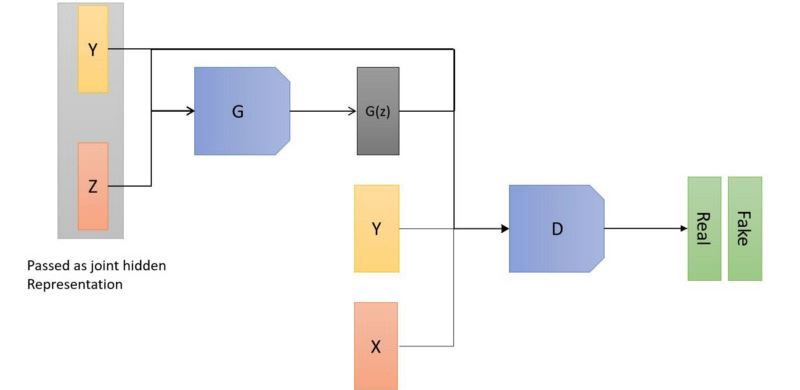

In [ ]:
if ctgan_synth_model == True:
  model = CTGAN(
    epochs=500,
    batch_size=100,
    generator_dim=(256, 256, 256),
    discriminator_dim=(256, 256, 256)
  )
  model.fit(data)
  model_names.append(dataset+'_ctgan.pkl')
  model.save(model_names[-1])

# **Synthetic Data Generation via Copula GAN**

The CopulaGAN model is a variation of the CTGAN Model which takes advantage of the CDF based transformation that the GaussianCopulas apply to make the underlying CTGAN model task of learning the data easier.




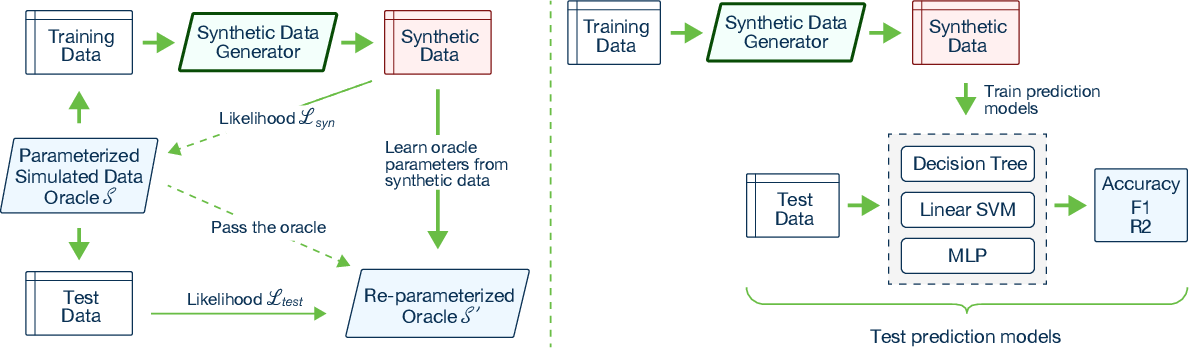

In [ ]:
if copula_gan_synth_model == True:
  model = CopulaGAN(
    epochs=500,
    batch_size=100,
    generator_dim=(256, 256, 256),
    discriminator_dim=(256, 256, 256)
  )
  model.fit(data)
  model_names.append(dataset+'_copulagan.pkl')
  model.save(model_names[-1])

/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:5320: RuntimeWarning: divide by zero encountered in true_divide
  return c**2 / (c**2 - n**2)
/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:2606: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:639: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:5311: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: 

# **Model Loading and Preparation**

In [ ]:
model_file = []
model_to_load = []
if gaussian_copula_synth_model == True:
  model_file.append(model_names[0])
  model_to_load.append(("GaussianCopula", GaussianCopula))
if ctgan_synth_model == True:
  model_file.append(model_names[-1])
  model_to_load.append(("CTGAN", CTGAN))
elif copula_gan_synth_model == True:
  model_file.append(model_names[-1])
  model_to_load.append(("COPULAGAN", CopulaGAN))

loaded_model = []
for mf,ml in zip(model_file, model_to_load): 
  loaded_model.append((ml[0], ml[1].load(mf)))

# **Synthetic Data Generation**

In [ ]:
synthetic_data = []
for lm in loaded_model: 
  synthetic_data.append((lm[0], lm[1].sample(n_to_generate)))

# **Synthetic Data Exploratory Analysis**

In [ ]:
scored_and_synth_data = []
for sd in synthetic_data:
  try:
    print("\nMethod: ",sd[0])
    explore_data(sd[1])
    score = evaluate(sd[1], data)
    print("\n\nScore: ", score)
    scored_and_synth_data.append((sd[0], sd[1], score))  
  except:
    print("Error")



Method:  COPULAGAN

Head of Data: 
   CHIAVE_NUM_CHIAMANTE DATA_CHIAMATA    ORA_MIN_CHIAMATA COD_CELLA_CHIAMATA
0    F1508316675572647    2017-02-02 1900-01-01 20:50:43               F206
1   F14615362915496210    2017-02-03 1900-01-01 15:22:18                F15
2   F14615442335644470    2017-01-25 1900-01-01 08:40:16                F83
3   F14615230806211460    2017-02-12 1900-01-01 16:45:27               F100
4   F14615166004947990    2017-02-02 1900-01-01 11:31:30               F350

Tail of Data: 
      CHIAVE_NUM_CHIAMANTE DATA_CHIAMATA    ORA_MIN_CHIAMATA COD_CELLA_CHIAMATA
9995   F14616947678379890    2017-01-23 1900-01-01 13:45:34               F101
9996   F14615169567198860    2017-02-03 1900-01-01 18:54:09               F493
9997   F14615366820272070    2017-01-31 1900-01-01 17:04:21               F644
9998   F14615339806425970    2017-02-01 1900-01-01 14:40:07                F15
9999   F14615244297124900    2017-01-26 1900-01-01 10:28:44               F328

Shape of Data: 

Output streaming troncato alle ultime 5000 righe.
/usr/local/lib/python3.7/dist-packages/sdmetrics/utils.py:62: UserWarning: Unexpected value Pandas(CHIAVE_NUM_CHIAMANTE='F1508348000516039', COD_CELLA_CHIAMATA='F477') in synthetic data.
  warnings.warn(f'Unexpected value {value} in synthetic data.')
/usr/local/lib/python3.7/dist-packages/sdmetrics/utils.py:62: UserWarning: Unexpected value Pandas(CHIAVE_NUM_CHIAMANTE='F14615224339316630', COD_CELLA_CHIAMATA='F64') in synthetic data.
  warnings.warn(f'Unexpected value {value} in synthetic data.')
/usr/local/lib/python3.7/dist-packages/sdmetrics/utils.py:62: UserWarning: Unexpected value Pandas(CHIAVE_NUM_CHIAMANTE='F14615224339316630', COD_CELLA_CHIAMATA='F359') in synthetic data.
  warnings.warn(f'Unexpected value {value} in synthetic data.')
/usr/local/lib/python3.7/dist-packages/sdmetrics/utils.py:62: UserWarning: Unexpected value Pandas(CHIAVE_NUM_CHIAMANTE='F14615426104544740', COD_CELLA_CHIAMATA='F565') in synthetic data.
  warnin



Score:  0.428515388112809


In [ ]:
total_time = timeit.default_timer() - start_global_time

In [ ]:
for sas in scored_and_synth_data:
  sas[1].to_csv(dataset+'_synth_data_generated_by_method_'+sas[0].lower()+'total_time_'+str(round(total_time,2))+'_score_'+str(round(sas[2],3))+'.csv', sep=',')

In [ ]:
for sas in scored_and_synth_data:
  sas[1].to_excel(dataset+'_synth_data_generated_by_method_'+sas[0].lower()+'total_time_'+str(round(total_time,2))+'_score_'+str(round(sas[2],3))+'.xlsx')

In [ ]:
print("Global Exectution Time: ", total_time)

Global Exectution Time:  3309.263267836


In [ ]:
#import seaborn as sns

#sns.set_theme(style="whitegrid")


In [ ]:
import pandas as pd

In [ ]:
#outputData=pd.read_excel("/content/telephony_synth_data_generated_by_method_copulagantotal_time_2676.59_score_0.36.xlsx")
outputData=pd.read_excel("/content/telephony_synth_data_generated_by_method_copulagantotal_time_3309.26_score_0.429.xlsx")

In [ ]:
#outputData["CHIAVE_NUM_CHIAMANTE"]=outputData.CHIAVE_NUM_CHIAMANTE#.astype("object")

In [ ]:
!pip install matplotlib==3.1.3

     |████████████████████████████████| 13.1 MB 5.4 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.2
    Uninstalling matplotlib-3.5.2:
      Successfully uninstalled matplotlib-3.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
copulas 0.6.1 requires matplotlib<4,>=3.4.0; python_version >= "3.7", but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


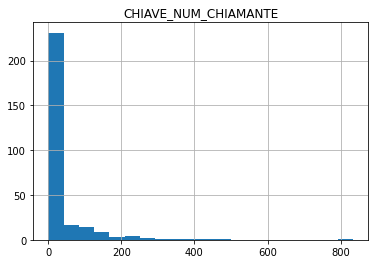

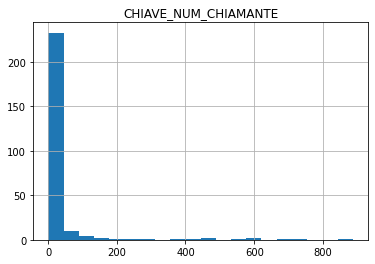

In [ ]:
from matplotlib import pyplot as plt

pd.DataFrame(data.CHIAVE_NUM_CHIAMANTE.value_counts()).hist(bins=20)
plt.show()

pd.DataFrame(outputData.CHIAVE_NUM_CHIAMANTE.value_counts()).hist(bins=20)
plt.show()
#che nessuno utente sintetico chiama piu' di una volta'

In [ ]:
A=set(data.CHIAVE_NUM_CHIAMANTE.astype("str"))
B=set(outputData.CHIAVE_NUM_CHIAMANTE.astype("str"))
B.difference(A)


set()

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   CHIAVE_NUM_CHIAMANTE  10000 non-null  object        
 1   DATA_CHIAMATA         10000 non-null  datetime64[ns]
 2   ORA_MIN_CHIAMATA      10000 non-null  datetime64[ns]
 3   COD_CELLA_CHIAMATA    10000 non-null  object        
dtypes: datetime64[ns](2), object(2)
memory usage: 312.6+ KB


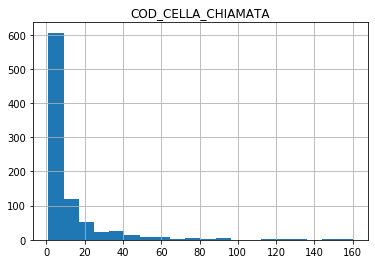

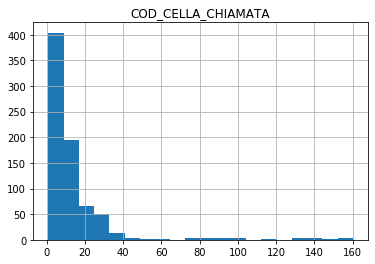

In [ ]:

pd.DataFrame(data.COD_CELLA_CHIAMATA.value_counts()).hist(bins=20)
plt.show()

pd.DataFrame(outputData.COD_CELLA_CHIAMATA.value_counts()).hist(bins=20)
plt.show()

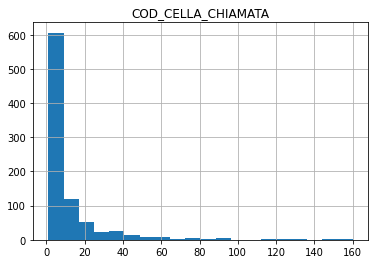

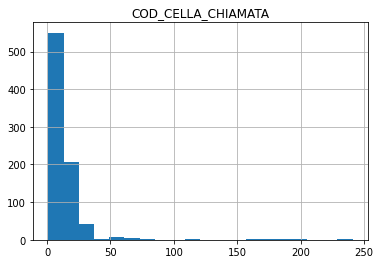

In [ ]:

pd.DataFrame(data.COD_CELLA_CHIAMATA.value_counts()).hist(bins=20)
plt.show()

pd.DataFrame(outputData.COD_CELLA_CHIAMATA.value_counts()).hist(bins=20)
plt.show()

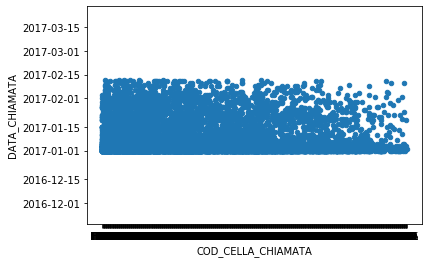

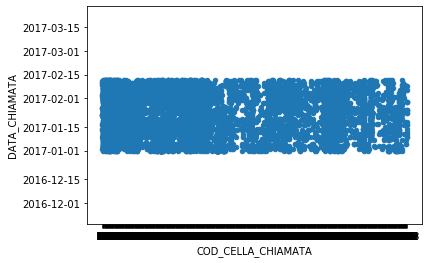

In [ ]:
outputData.plot.scatter("COD_CELLA_CHIAMATA","DATA_CHIAMATA")
plt.show()
data.plot.scatter("COD_CELLA_CHIAMATA","DATA_CHIAMATA")
plt.show()

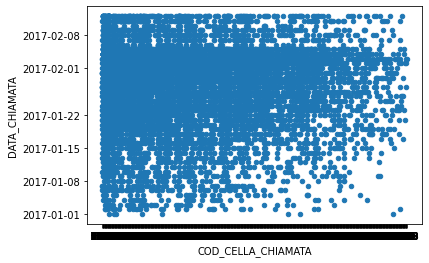

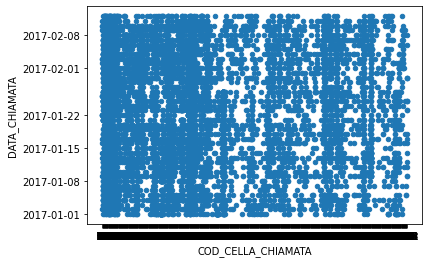

In [ ]:
outputData.plot.scatter("COD_CELLA_CHIAMATA","DATA_CHIAMATA")
plt.show()
data.plot.scatter("COD_CELLA_CHIAMATA","DATA_CHIAMATA")
plt.show()

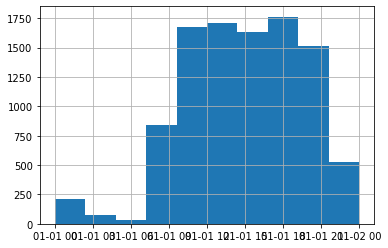

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Unnamed: 0            10000 non-null  int64         
 1   CHIAVE_NUM_CHIAMANTE  10000 non-null  object        
 2   DATA_CHIAMATA         10000 non-null  datetime64[ns]
 3   ORA_MIN_CHIAMATA      10000 non-null  object        
 4   COD_CELLA_CHIAMATA    10000 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 390.8+ KB


,Unnamed: 0,CHIAVE_NUM_CHIAMANTE,DATA_CHIAMATA,ORA_MIN_CHIAMATA,COD_CELLA_CHIAMATA
0,0,F14615426766768880,2017-01-15,18:13:25,F758
1,1,F14615205906858960,2017-01-15,22:04:40,F661
2,2,F14615362915496210,2017-01-03,23:58:43,F349
3,3,F14615366820272070,2017-01-02,16:47:53,F133
4,4,F14615362915496210,2017-01-01,19:40:53,F337
...,...,...,...,...,...
9995,9995,F14615169567198860,2017-01-15,17:05:13,F200
9996,9996,F14615362915496210,2017-01-06,22:39:48,F13
9997,9997,F14615362915496210,2017-01-21,23:11:26,F234
9998,9998,F14615169567198860,2017-01-02,18:15:39,F311


In [ ]:
data.ORA_MIN_CHIAMATA.hist()
plt.show()
outputData.info()#ORA_MIN_CHIAMATA..hist()
outputData

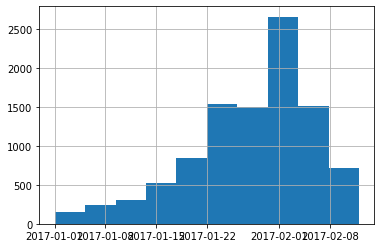

In [ ]:
#outputData.ORA_MIN_CHIAMATA.to_datetime().hist()
#plt.show()
pd.to_datetime(outputData.DATA_CHIAMATA, format='%Y%m%d').hist()

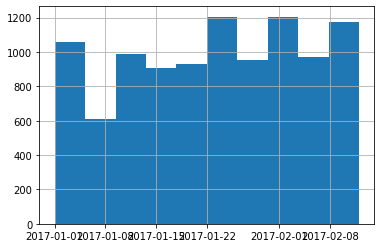

In [ ]:
pd.to_datetime(data.DATA_CHIAMATA, format='%Y%m%d').hist()

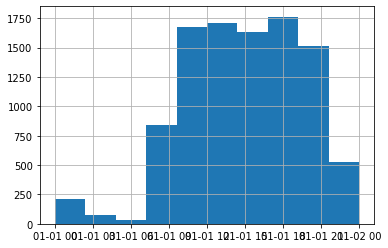

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Unnamed: 0            10000 non-null  int64         
 1   CHIAVE_NUM_CHIAMANTE  10000 non-null  object        
 2   DATA_CHIAMATA         10000 non-null  datetime64[ns]
 3   ORA_MIN_CHIAMATA      10000 non-null  object        
 4   COD_CELLA_CHIAMATA    10000 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 390.8+ KB


,Unnamed: 0,CHIAVE_NUM_CHIAMANTE,DATA_CHIAMATA,ORA_MIN_CHIAMATA,COD_CELLA_CHIAMATA
0,0,F1508316675572647,2017-02-02,20:50:43,F206
1,1,F14615362915496210,2017-02-03,15:22:18,F15
2,2,F14615442335644470,2017-01-25,08:40:16,F83
3,3,F14615230806211460,2017-02-12,16:45:27,F100
4,4,F14615166004947990,2017-02-02,11:31:30,F350
...,...,...,...,...,...
9995,9995,F14616947678379890,2017-01-23,13:45:34,F101
9996,9996,F14615169567198860,2017-02-03,18:54:09,F493
9997,9997,F14615366820272070,2017-01-31,17:04:21,F644
9998,9998,F14615339806425970,2017-02-01,14:40:07,F15


In [ ]:
data.ORA_MIN_CHIAMATA.hist()
plt.show()
outputData.info()#ORA_MIN_CHIAMATA..hist()
outputData

In [ ]:
data.ORA_MIN_CHIAMATA.hist()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
pd.read_excel("")

In [ ]:
inputData=sas[1]
#inputData.COD_CELLA_CHIAMATA.value_counts()
pd.DataFrame(inputData).COD_CELLA_CHIAMATA.plot()#.bar()

ImportError: ignored

<Figure size 432x288 with 1 Axes>

In [ ]:
data.COD_CELLA_CHIAMATA.value_counts()

18     160
1      158
15     155
644    148
21     135
      ... 
435      1
723      1
724      1
725      1
501      1
Name: COD_CELLA_CHIAMATA, Length: 884, dtype: int64

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#pd.read_csv("/content/drive/MyDrive/fatture-01_05_2020-01_08_2020.csv",sep=";")

In [ ]:
datetime64

NameError: ignored